In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from elasticsearch import Elasticsearch
from datetime import datetime,date,timedelta 
from statsmodels.tsa.stattools import adfuller
from pandas import Series
from pmdarima import auto_arima
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product

In [47]:
def lic_server_dataextraction_count(site,lic_name,days):
    es = Elasticsearch(['snpstemp054'])
    day = str(days)+'d'
    #print(day)
    a= str(datetime.utcnow().date() - timedelta(days=0)) + ' 0-0-0'
    date2 = datetime.strptime(a, '%Y-%m-%d %H-%M-%S')
    delta = timedelta(days=days)
    date1 = date2 - delta
    date1=date1.strftime("%Y-%m-%d"'T'"%H:%M:%S")
    date2=date2.strftime("%Y-%m-%d"'T'"%H:%M:%S")
    #print(date2)
    #print(date1)
    query ='{\
                  "size":1000,\
                  "query": {\
                    "bool": {\
                      "must": [\
                        {\
                          "query_string": {\
                                "query": "type : \\"client_info\\"  AND site:'+site+' AND lic_name: \\"'+lic_name+'\\"  "\
                          }\
                        },\
                            {\
                  "range": {\
                    "@timestamp": {\
                      "gte": "'+date1+'",\
                      "lte": "'+date2+'"\
                    }\
                  }\
                }\
                      ]\
                    }\
                  }\
                }'
    data = []
    res = es.search(index="lic_beat-2019", scroll="2m", body=query)
    sid = res['_scroll_id']
    scroll_size = res['hits']['total']
    while (scroll_size > 0):
        for item in res["hits"]["hits"]:
            hit=item['_source']
            data.append(hit)
        res = es.scroll(scroll_id = sid, scroll= "2m")
        sid = res['_scroll_id']
        scroll_size = len(res["hits"]["hits"])
    df = pd.DataFrame(data)
    df = df.sort_values('@timestamp',ascending= False).reset_index(drop = True)
    #print(df.head(4))
    df['@timestamp'] = pd.to_datetime(df['@timestamp']//1000,unit='s')
    pda = df.loc[:, ['@timestamp', 'client_count']]
    pda.columns = ['ds','y']
    pda = pda.set_index('ds')
    pda1= pda.resample('H').max()  
    pda1 = pda1.fillna(method='ffill')
    pda1 = pda1.sort_values('ds',ascending= True)
    pda1.y = np.where(((pda1.y - pda1.y.mean()) / pda1.y.std()).abs() > 3 ,pda1.y.median(), pda1.y)
    return pda1

In [48]:
df=lic_server_dataextraction_count('us01','us01-vglic3-new',60)

INFO:elasticsearch:GET http://snpstemp054:9200/lic_beat-2019/_search?scroll=2m [status:200 request:0.028s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0.026s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0.028s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0.028s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0.029s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0.028s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0.028s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0.030s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0.028s]
INFO:elasticsearch:GET http://snpstemp054:9200/_search/scroll?scroll=2m [status:200 request:0

In [49]:
def transformations(df,trans):
    
    if trans=='log':
        df= np.log(df)
        return df
    
    elif trans=='diff':
        diff = list()
        for i in range(1, len(df)):
            value = df[i] - df[i - 1]
            diff.append(value)
        return Series(diff[1:])
    

In [52]:
def stationarytest(df):
    for i in range(0,4):
        print("\n\nChecking stationarity for order: ",i)
        j=0;
        y=df.y
        while(j<i):
            y=transformations(y,'diff')
            j=j+1
        result=adfuller(y)
        print('ADF Statistic : %f'%result[0])
        print('pvalue : %f ' % result[1])
        print('Critical Values:')
        for key,value in result[4].items():
            print('\t%s : %3f\n' %(key,value))
        

In [53]:
stationarytest(df)



Checking stationarity for order:  0
ADF Statistic : -2.368540
pvalue : 0.150813 
Critical Values:
	1% : -3.438439

	5% : -2.865110

	10% : -2.568671



Checking stationarity for order:  1
ADF Statistic : -17.478061
pvalue : 0.000000 
Critical Values:
	1% : -3.438459

	5% : -2.865119

	10% : -2.568676



Checking stationarity for order:  2
ADF Statistic : -13.034440
pvalue : 0.000000 
Critical Values:
	1% : -3.438479

	5% : -2.865128

	10% : -2.568681



Checking stationarity for order:  3
ADF Statistic : -16.188416
pvalue : 0.000000 
Critical Values:
	1% : -3.438459

	5% : -2.865119

	10% : -2.568676



In [54]:
def performance(data,metric):
    
    if metric=='mae':
        mae = mean_absolute_error(data.y,data.yhat)
        print('MAE: %f' % mae)
    
    elif metric=='rmse':
        mse = mean_squared_error(data.y,data.yhat)
        rmse = sqrt(mse)
        print('RMSE: %f' % rmse)

    


In [95]:
def arima_modeling(dftrain,dftest,seasonality,arima_diff,performance_metric):

    arima_model = auto_arima(dftrain, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=seasonality,
                           start_P=0,start_Q=0,max_P=3,max_Q=3 ,seasonal=True,
                           d=arima_diff, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    
    future_forecast = arima_model.predict(n_periods=len(dftest))
    forecast=pd.DataFrame(future_forecast,columns=['yhat'])
    dftest['ds']=dftest.index
    dftest=dftest.reset_index(drop=True)
    forecast['y']=dftest.y
    print(dftest.y)
    print(forecast)
    plt.figure(figsize=(20,10))
    plt.style.use('seaborn')
    plt.plot(forecast.y,color = 'b')
    plt.plot(forecast.yhat,color = 'r')
    
    metric_value=performance(dftest,performance_metric)
    
    return arima_model,dftest,metric_value
    

In [102]:
def trainprophet(dftrain,dftest,changepoint,weekly,daily):
    
    m=Prophet(weekly_seasonality=weekly,daily_seasonality=daily,yearly_seasonality=False,interval_width=0.95,changepoint_prior_scale=changepoint,growth="logistic")
    m.fit(dftrain)

    future=m.make_future_dataframe(periods=len(dftest),freq='H')
    future['cap']=10
    future['floor']=1
   
    forecast=m.predict(future)
    
    return forecast,m



def tunefor(dftrain,dftest):

    changepointscale=[0.9,0.7,0.5,0.3]
    weekly=[5,10]
    dialy=[5,10]
    params=product(changepointscale,weekly,dialy)
    params=list(params)


    dfnew = pd.concat([dftrain, dftest])
    dfnew=dfnew.reset_index(drop=True)

    resultable= pd.DataFrame(columns=['param','mae'])
    count=1
    for param in params:

        print("Iteration:",count)
        count=count+1
        forecast,forecast_model=trainprophet(dftrain,dftest,param[0],param[1],param[2])
        forecast['y']=dfnew.y
        split=len(dftrain)
        mae=mean_absolute_error(forecast.y[split:],forecast.yhat[split:])
        resultable=resultable.append({'param':param,'mae':mae},ignore_index=True)

    resultable = resultable.sort_values(['mae'],ascending = True).reset_index(drop=True)
    print(resultable)
    paramfixed=resultable['param'][0]
    print(paramfixed)

    best_model_forecast,best_model=trainprophet(dftrain,dftest,paramfixed[0],paramfixed[1],paramfixed[2])
    best_model_forecast['y']=dfnew.y
    #print("forecast",best_model_forecast)
    
    
    return best_model,best_model_forecast[len(dftrain):]

def prophet_modeling(dftrain,dftest,seasonality,performance_metric):
    
    dftrain['cap']=10
    dftrain['ds']=dftrain.index
    dftest['floor']=1
    prophet_model,prophet_forecast=tunefor(dftrain,dftest)
    metric_value=performance(dftest,performance_metric)
    
    return prophet_model,prophet_forecast,metric_value
    
    
    

In [103]:
def models(df,split,seasonality,performance_metric,arima_diff):
    
    dftrain=df[:round(split*len(df))]
    dftest=df[round(split*len(df)):]
    
    arima_model,arima_forecast,arima_metric_value=arima_modeling(dftrain,dftest,seasonality,arima_diff,performance_metric)
    
    prophet_model,prophet_forecast,prophet_metric_value=prophet_modeling(dftrain,dftest,seasonality,performance_metric)
    
    
    


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 2); AIC=9137.161, BIC=9155.148, Fit time=0.293 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 2); AIC=9471.323, BIC=9480.316, Fit time=0.047 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 2); AIC=9190.990, BIC=9208.977, Fit time=0.363 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 2); AIC=8869.849, BIC=8887.836, Fit time=0.415 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 2); AIC=8870.560, BIC=8893.044, Fit time=0.510 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 2); AIC=9159.886, BIC=9173.376, Fit time=0.199 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 2); AIC=8870.519, BIC=8893.003, Fit time=0.646 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 2); AIC=8873.867, BIC=8900.848, Fit time=0.570 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 2); AIC=8830.585, BIC=8853.069, Fit time=0.782 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_o

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

0       28.0
1       22.0
2       26.0
3      135.0
4      374.0
5      453.0
6      341.0
7      285.0
8      269.0
9      144.0
10     390.0
11     389.0
12     319.0
13     306.0
14     282.0
15     333.0
16     260.0
17      50.0
18      46.0
19      25.0
20      18.0
21      26.0
22      17.0
23      24.0
24      28.0
25     156.0
26      27.0
27     157.0
28     442.0
29     522.0
       ...  
137     24.0
138     16.0
139     17.0
140     26.0
141     15.0
142     22.0
143     27.0
144     27.0
145     24.0
146     25.0
147    129.0
148    806.0
149    867.0
150    487.0
151    800.0
152    318.0
153    337.0
154    313.0
155    196.0
156    340.0
157    213.0
158    146.0
159    160.0
160     22.0
161     18.0
162     21.0
163     23.0
164     16.0
165     14.0
166     24.0
Name: y, Length: 167, dtype: float64
           yhat      y
0     54.590227   28.0
1     81.201458   22.0
2     80.293046   26.0
3     91.522421  135.0
4     92.905754  374.0
5     99.185463  453.0
6     93.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 1
Iteration: 2


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 3


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 4


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 5


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 6


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 7


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 8


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 9


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 10


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 11


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 12


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 13


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 14


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 15


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



Iteration: 16


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



            param         mae
0     (0.9, 5, 5)  230.435215
1     (0.3, 5, 5)  230.460564
2     (0.5, 5, 5)  230.485336
3    (0.5, 10, 5)  230.495408
4     (0.7, 5, 5)  230.522641
5    (0.7, 10, 5)  230.578217
6    (0.3, 10, 5)  230.586195
7    (0.9, 10, 5)  230.600235
8    (0.5, 5, 10)  230.936272
9    (0.7, 5, 10)  230.987200
10   (0.3, 5, 10)  230.996789
11   (0.9, 5, 10)  231.027035
12  (0.5, 10, 10)  231.080076
13  (0.3, 10, 10)  231.134412
14  (0.9, 10, 10)  231.155973
15  (0.7, 10, 10)  231.181316
(0.9, 5, 5)


/opt/conda/lib/python3.6/site-packages/fbprophet/forecaster.py:266: FutureWarning:

'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version



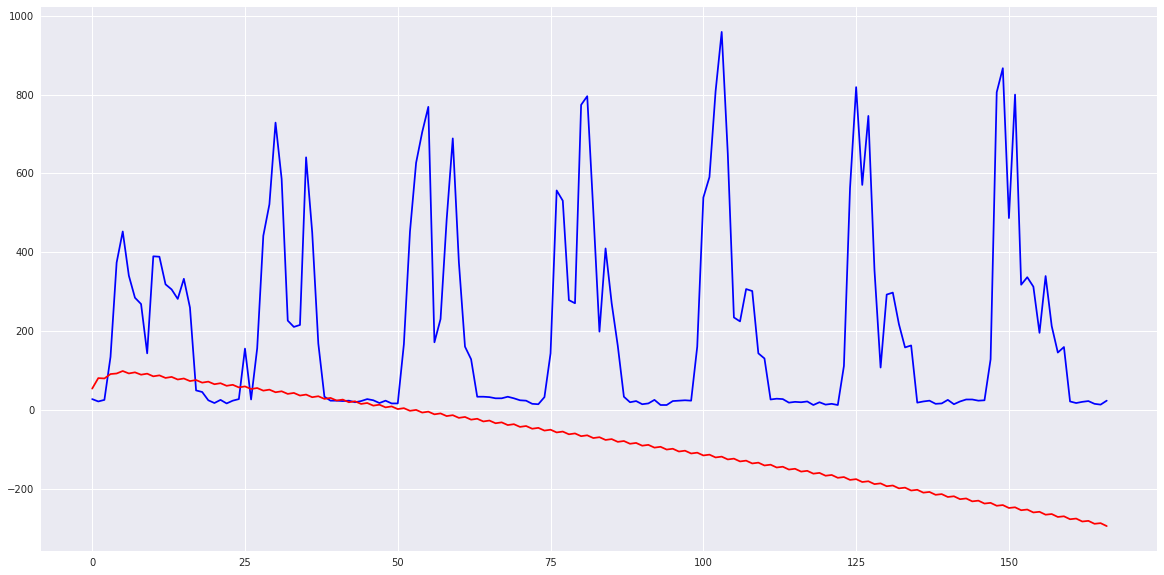

In [104]:
model=models(df,0.8,2,'h',1)